In [318]:
import numpy as np
from torchvision import datasets
from tqdm import tqdm

np.random.seed(123)

# MLP implementation by hand

## Forward Prop (intuiton + applying)

### Intuiton:
The ideia is to pass an input through the neurons in each layer, computing a mlp + an activation function. Reaching the output in which it will be computed a Loss function.

To achieve this we need: data (input), neurons (funct), layers (matrix of neurons)

The MNIST dataset will be applied to replicate results using similar architectures

### Data: MNIST Dataset

In [319]:
train_dataset = datasets.MNIST(
    root = "data",
    train=True,
    download=True
)

test_dataset = datasets.MNIST(
    root = "data",
    train=False,
    download=True
)

Pre loading data to access an np array


In [320]:
# #Just checking the dataset type and how to grab its values
# i = 0
# data = np.zeros((784, len(test_dataset)))
# labels = np.zeros((len(test_dataset), 1))

# for X, y in test_dataset:

#     x = np.array(X.getdata())
#     x = x / 255
#     data[:,i] = x
#     labels[i] = y
#     i += 1


# i = 0
# train_data = np.zeros((784, len(train_dataset)))
# train_labels = np.zeros((len(train_dataset), 1))

# for X, y in tqdm(train_dataset):

#     x = np.array(X.getdata())
#     x = x / 255
#     train_data[:,i] = x
#     train_labels[i] = y
#     i += 1

def pre_process_data(dataset):

    dataset_size = len(dataset)
    X, _ = dataset[0]
    img_size = len(X.getdata())
    data = np.zeros((img_size, dataset_size))
    labels = np.zeros((dataset_size, 1))

    i=0
    for X, y in tqdm(dataset):
        x = np.array(X.getdata())
        x = x / 255
        data[:,i] = x
        labels[i] = y
        i += 1

    data_mean = np.mean(data)
    data_std = np.std(data-data_mean)

    data = (data - data_mean) / data_std

    return data, labels

train_data, train_labels = pre_process_data(train_dataset)
test_data, test_labels = pre_process_data(test_dataset)

100%|██████████| 10000/10000 [00:00<00:00, 21456.24it/s]


Just checking if data array contains correct data

In [321]:
print(test_data.shape)
check = test_data[:,:5]*255
print(sum(check))

i = 0
for X, y in test_dataset:

    print(sum(np.array(X.getdata())), end=" ")
    if i == 4:
        break
    i+=1

(784, 10000)
[-25889.95613595   7593.65536363 -53534.22676897  33888.40375557
 -23368.05657802]
18454 28850 9871 37014 19237 

# Building network
Non vectorized implementation

In [322]:
from math import sqrt
from numpy.random import randn


def neuron(X, W, b):
    """Computing by hand each neuron
    X (input) -> (in, 1) matrix
    W (weights) -> (1, in) matrix
    b (bias) -> (1, 1) scalar"""
    z = W @ X + b
    
    return z


def ReLU(z):
    a = np.maximum(0.000000001, z)
    return a


def softmax(a):
    """Calculating a softmax activation function:
    Using e^z / m * sum( e^zi ) """
    a_exp = np.exp(a)
    sum_a_exp = np.sum(a_exp, axis=0)

    for i in range(a.shape[1]):
        a[:,i] = a_exp[:,i] / sum_a_exp[i]

    return a


def cross_entropy(logits, y):
    pred_truth = logits[y]
    loss = - np.log(pred_truth)

    return loss


def get_pred(logits):

    arg = np.argmax(logits)

    return arg


def batch_norm_forward(batch, gamma, beta, eps=1e-5):
    
    mean_b = np.mean(batch, axis=0, keepdims=True)
    std_b = np.mean((batch - mean_b)**2, axis=0,keepdims=True)
    x_hat = (batch - mean_b) / ((std_b + eps)**(1/2))
    out = gamma * x_hat + beta

    cache = (gamma, x_hat, std_b, mean_b, batch, eps)

    return out, cache


def layer(output, input, W, b, gamma=None, beta=None, activ_funct=None):
    """Computing the value of a whole layer of neurons, so it will use the entry (X), multiplied by the Weights (W) + Bias 
    The ideia is to compute for each layer its output values, consisting of a matrix of (neurons, 1)"""
    a = np.zeros((output, input.shape[1]))

    if activ_funct == "ReLU":

        z = neuron(X=input, W=W, b=b)
        n, norm_cax = batch_norm_forward(z, gamma, beta)
        a = ReLU(n)
        
    elif activ_funct == "softmax": 

        z = neuron(X=input, W=W, b=b)
        a = softmax(z)
        n = None
        norm_cax = None
    
    return a, z, n, norm_cax


In [323]:
cache = {}

def get_wb(output, X_len):
    std = sqrt(2.0 / X_len)
    W_in = randn(output, X_len)
    W = W_in * std
    b = randn(output, 1)
    b = b * std

    return W, b

#TODO: Create a model class to encompass both functions in one, creating each layer and if Wn does not exist, create Wn
def model_weights(data):
    
    cache["W1"], cache["b1"] = get_wb(1024, data.shape[0])
    cache["W2"], cache["b2"] = get_wb(512, 1024)
    cache["W3"], cache["b3"] = get_wb(10, 512)
    cache["gamma1"] = np.ones((cache["W1"].shape[0], 1))
    cache["gamma2"] = np.ones((cache["W2"].shape[0], 1))
    cache["beta1"] = np.zeros((cache["W1"].shape[0], 1))
    cache["beta2"] = np.zeros((cache["W2"].shape[0], 1))
    # cache["bmean_run1"] = np.zeros((cache["W1"].shape[0], 1))
    # cache["bstd_run1"] = np.ones((cache["W1"].shape[0], 1))
    # cache["bmean_run2"] = np.zeros((cache["W2"].shape[0], 1))
    # cache["bstd_run2"] = np.ones((cache["W2"].shape[0], 1))

    return cache

def dropout(input, keep_prob):
    '''gets weight matrix and prob estimate'''
    D = np.random.rand(*input.shape)
    mask = D < keep_prob
    adj_input = input * mask
    adj_input = adj_input / keep_prob

    return adj_input, mask, keep_prob

def dropout_backprop(dA, mask, keep_prob):
    ddrop = dA * mask
    ddrop = ddrop / keep_prob

    return ddrop


def batch_norm_backward(dout, cache):
    gamma, x_hat, std_b, mean_b, batch, eps = cache
    _, N = batch.shape

    dgamma = np.sum(dout * x_hat, axis=1, keepdims=True)
    dbeta = np.sum(dout, axis=1, keepdims=True)
    dx_hat = dout * gamma #is it a vector?

    # dx_std = np.sum(dx_hat * ((batch - mean_b)*-1/2*(std_b + eps)**(-3/2)), axis=0, keepdims=True)
    # dx_mu = np.sum(dx_hat * -1* (std_b + eps)**(1/2), axis=0, keepdims=True) + dx_std * np.sum(-2* (batch-mean_b))/N
    # dx_size_check = dx_mu * 1/N + dx_std * 2* (batch-mean_b)/N + dx_hat * 1/((std_b+eps)**(1/2))
    dx = (1./N) * (std_b + eps)**(-0.5) * (N*dx_hat - np.sum(dx_hat, axis=0) - x_hat * np.sum(dx_hat * x_hat, axis=0))
    # print(f"dout: {dout.shape}")
    # print(f"dx: {dx.shape}")
    return dx, dgamma, dbeta

In [324]:
def forward(X, cache, keep_prob_d1=1, keep_prob_d2=1):

    L1, Z1, N1, N1_cache  = layer(cache["W1"].shape[0], X, activ_funct="ReLU", W=cache["W1"], b=cache["b1"], gamma=cache["gamma1"], beta=cache["beta1"])
    #Norm1, Norm1_cache = batch_norm_forward(L1, gamma=cache["gamma1"], beta=cache["beta1"])
    D1, D1_mask, D1_prob = dropout(L1, keep_prob=keep_prob_d1)

    L2, Z2, N2, N2_cache  = layer(cache["W2"].shape[0], D1, activ_funct="ReLU", W=cache["W2"], b=cache["b2"], gamma=cache["gamma2"], beta=cache["beta2"])
    #Norm2, Norm2_cache = batch_norm_forward(L2, gamma=cache["gamma2"], beta=cache["beta2"])
    D2, D2_mask, D2_prob = dropout(L2, keep_prob=keep_prob_d2)
    
    L3, Z3, _, _ = layer(cache["W3"].shape[0], D2, activ_funct="softmax", W=cache["W3"], b=cache["b3"])
    
    cache["A1"] = L1
    cache["A2"] = L2
    cache["A3"] = L3

    cache["Z1"] = Z1
    cache["Z2"] = Z2
    cache["Z3"] = Z3

    cache["D1"] = D1
    cache["D2"] = D2

    cache["N1"] = N1
    cache["N2"] = N2

    cache["N1_cache"] = N1_cache
    cache["N2_cache"] = N2_cache

    cache["D1_mask"] = D1_mask
    cache["D2_mask"] = D2_mask

    cache["D1_prob"] = D1_prob
    cache["D2_prob"] = D2_prob
    
    return L3, cache

In [325]:
def test(dataset, labels, loss_fn, cache, reg=False, keep_prob_d1=1, keep_prob_d2=1):

    loss = 0
    correct = 0

    all_preds, cache = forward(dataset, cache, keep_prob_d1=keep_prob_d1, keep_prob_d2=keep_prob_d2)
        
    for i in range(all_preds.shape[1]):
        logits = all_preds[:, i]
        pred = get_pred(logits)
        y = int(labels[i][0])
        loss += loss_fn(logits, y)
        correct += int(pred == y)

    acc = correct / all_preds.shape[1]
    loss = loss / all_preds.shape[1]

    if reg:
        w_sum = 0
        for k in cache.keys():
            if k[0] == 'W':
                w_sum = w_sum + np.linalg.norm(cache[k])
        loss = loss + reg/(2*all_preds.shape[1]) * w_sum

    return loss, acc, correct, cache


In [326]:
def one_hot_enc(labels):

    Y_one_hot = np.zeros((10, labels.size))
    label = np.array(labels, dtype=int)[:,0]
    Y_one_hot[label, np.arange(label.size)] = 1

    return Y_one_hot


# Implementing BackProp
### Using SGD on the model created above

#### Implementation: Computing the derivative of each computation on the NN forward network, working backwards to update the weights. The implementation will be made in a vectorized manner directly

In [327]:
def adam_optimizer(weight, deriv, learning_rate, iter, beta_1=0.9, beta_2=0.99, eps=1e-8, Vd=None, Sd=None):
    #MOMENTUM
    Vd = beta_1 * Vd + (1 - beta_1) * deriv
    #Starting the param
    Vd = Vd / (1 - beta_1**iter)

    #RMSProp
    Sd = beta_2 * Sd + (1 - beta_2) * deriv**2
    Sd = Sd / (1-beta_2**iter)

    #Update
    weight = weight - learning_rate * Vd / (np.sqrt(Sd + eps))

    return weight, Vd, Sd

In [328]:
def backprop(cache, batch, labels, learning_rate, reg, iter):
    deriv = {}
    cache["X"] = batch
    cache["Y"] = one_hot_enc(labels)

    Z2 = cache["Z2"]
    relu_Z2 = 1*(Z2 >= 0)

    Z1 = cache["Z1"]
    relu_Z1 = 1*(Z1 >= 0)

    dz3 = (cache["A3"] - cache["Y"]) # * (-1/cache["A3"])
    dw3 = (dz3 @ cache["A2"].T) / batch.shape[1]
    db3 = (np.sum(dz3, keepdims=True, axis=1)) / batch.shape[1]

    dA2 = cache["W3"].T @ dz3

    D2_mask = cache["D2_mask"]
    D2_prob = cache["D2_prob"]
    dA2 = dropout_backprop(dA2, D2_mask, D2_prob)
    #dA2, dgamma2, dbeta2 = batch_norm_backward(dA2, cache["N2_cache"])

    dz2 = dA2 * relu_Z2
    dw2 = (dz2 @ cache["A1"].T) / batch.shape[1]
    db2 = (np.sum(dz2, keepdims=True, axis=1)) / batch.shape[1]
    
    dA1 = cache["W2"].T @ dz2

    D1_mask = cache["D1_mask"]
    D1_prob = cache["D1_prob"]
    dA1 = dropout_backprop(dA1, D1_mask, D1_prob)
    #dA1, dgamma1, dbeta1 = batch_norm_backward(dA1, cache["N1_cache"])
    
    dz1 = dA1 * relu_Z1
    dw1 = (dz1 @ cache["X"].T) / batch.shape[1]
    db1 = (np.sum(dz1, keepdims=True, axis=1)) / batch.shape[1]

    deriv['dw1'] = dw1
    deriv['dw2'] = dw2
    deriv['dw3'] = dw3
    deriv['db1'] = db1
    deriv['db2'] = db2
    deriv['db3'] = db3

    #REGULARIZATION - SALVADORA DEMAISSSSSSSSSSSSSSSSSSS
    #Weight decay - To add this we NEED TO CHANGE THE LOSS FUNCT
    # dw3 += reg/batch.shape[1] * cache["W3"]
    # dw2 += reg/batch.shape[1] * cache["W2"]
    # dw1 += reg/batch.shape[1] * cache["W1"]

    #ADAM implementation
    try:
        Vdw3 += 1
    except UnboundLocalError:
        Vdw3 = Sdw3 = Vdb3 = Sdb3 = Vdw2 = Sdw2 = Vdb2 = Sdb2 = Vdw1 = Sdw1 = Vdb1 = Sdb1 = Vdg2 = Vdg1 = Sdg2 = Sdg1 = Vdbet2 = Vdbet1 = Sdbet2 = Sdbet1 = 0
        
    cache["W3"], Vdw3, Sdw3 = adam_optimizer(cache["W3"], dw3, learning_rate=learning_rate, iter=iter, Vd=Vdw3, Sd=Sdw3)
    cache["b3"], Vdb3, Sdb3 = adam_optimizer(cache["b3"], db3, learning_rate=learning_rate, iter=iter, Vd=Vdb3, Sd=Sdb3)

    # cache["gamma2"], Vdg2, Sdg2 = adam_optimizer(cache["gamma2"], dgamma2, learning_rate=learning_rate, iter=iter, Vd=Vdg2, Sd=Sdg2)
    # cache["beta2"], Vdb2, Sdb2 = adam_optimizer(cache["beta2"], dbeta2, learning_rate=learning_rate, iter=iter, Vd=Vdb2, Sd=Sdb2)
    
    cache["W2"], Vdw2, Sdw2 = adam_optimizer(cache["W2"], dw2, learning_rate=learning_rate, iter=iter, Vd=Vdw2, Sd=Sdw2)
    cache["b2"], Vdb2, Sdb2 = adam_optimizer(cache["b2"], db2, learning_rate=learning_rate, iter=iter, Vd=Vdb2, Sd=Sdb2)
    
    # cache["gamma1"], Vdg1, Sdg1 = adam_optimizer(cache["gamma1"], dgamma1, learning_rate=learning_rate, iter=iter, Vd=Vdg1, Sd=Sdg1)
    # cache["beta1"], Vdb1, Sdb1 = adam_optimizer(cache["beta1"], dbeta1, learning_rate=learning_rate, iter=iter, Vd=Vdb1, Sd=Sdb1)

    cache["W1"], Vdw1, Sdw1 = adam_optimizer(cache["W1"], dw1, learning_rate=learning_rate, iter=iter, Vd=Vdw1, Sd=Sdw1)
    cache["b1"], Vdb1, Sdb1 = adam_optimizer(cache["b1"], db1, learning_rate=learning_rate, iter=iter, Vd=Vdb1, Sd=Sdb1)

    
    iter += 1
    return cache, iter, deriv

In [329]:
def train(dataset, labels, learning_rate, loss_fn, cache, batch_size, reg, iter=1, keep_prob_d1=1, keep_prob_d2=1):

    size = dataset.shape[1]
    for i in tqdm(range(0, size, batch_size)):

        if i+batch_size > size:
            mini_batch = dataset[:, i:size]
            mini_y = labels[i:size]
        else:
            mini_batch = dataset[:, i:i+batch_size]
            mini_y = labels[i:i+batch_size]
            
        loss, acc, _, cache_updt = test(mini_batch, mini_y, loss_fn, cache, reg=reg, keep_prob_d1=keep_prob_d1, keep_prob_d2=keep_prob_d2)
        cache_final, iter, deriv = backprop(cache_updt, mini_batch, mini_y, learning_rate=learning_rate,reg=reg, iter=iter)

    return loss, acc, cache_final, iter, deriv

In [330]:
learning_rate = 1e-4
reg = 0.01
epochs = 30
batch_size = 128
keep_prob_d1 = 0.6
keep_prob_d2 = 0.75
cache = model_weights(train_data)

for i in range(epochs):
    test_loss, test_acc, test_correct, _ = test(test_data, test_labels, loss_fn=cross_entropy, cache=cache, reg=reg)
    print(f"TEST ---- loss: {test_loss:.2f}, acc (%): {test_acc*100:.2f}, correct: {test_correct}")
    loss, acc, correct, _ = test(train_data, train_labels, loss_fn=cross_entropy, cache=cache, reg=reg)
    print(f"TRAIN --- loss: {loss:.2f}, acc (%): {acc*100:.2f}, correct: {correct}")

    batch_loss, batch_acc, cache, iter, _ = train(train_data, train_labels, learning_rate=learning_rate, loss_fn=cross_entropy, cache=cache, batch_size=batch_size, reg=reg, keep_prob_d1=keep_prob_d1, keep_prob_d2=keep_prob_d2)
    print(f"Epoch: {i+1}, batch_loss: {batch_loss:.2f}, acc (%): {acc*100:.2f}")


print("\n\n")
loss, acc, correct, _ = test(test_data, test_labels, loss_fn=cross_entropy, cache=cache)
print(f"TEST ----- loss: {loss:.2f}, acc (%): {acc*100:.2f}, correct: {correct}")

loss, acc, correct, _ = test(train_data, train_labels, loss_fn=cross_entropy, cache=cache)
print(f"TRAIN ---- loss: {loss:.2f}, acc (%): {acc*100:.2f}, correct: {correct}")

TEST ---- loss: 2.67, acc (%): 8.79, correct: 879
TRAIN --- loss: 2.66, acc (%): 8.48, correct: 5090


100%|██████████| 469/469 [00:17<00:00, 26.69it/s]


Epoch: 1, batch_loss: 0.35, acc (%): 8.48
TEST ---- loss: 0.24, acc (%): 92.93, correct: 9293
TRAIN --- loss: 0.25, acc (%): 92.49, correct: 55495


100%|██████████| 469/469 [00:16<00:00, 27.90it/s]


Epoch: 2, batch_loss: 0.27, acc (%): 92.49
TEST ---- loss: 0.19, acc (%): 94.52, correct: 9452
TRAIN --- loss: 0.19, acc (%): 94.45, correct: 56672


100%|██████████| 469/469 [00:17<00:00, 27.29it/s]


Epoch: 3, batch_loss: 0.21, acc (%): 94.45
TEST ---- loss: 0.16, acc (%): 95.38, correct: 9538
TRAIN --- loss: 0.15, acc (%): 95.46, correct: 57275


100%|██████████| 469/469 [00:18<00:00, 25.76it/s]


Epoch: 4, batch_loss: 0.23, acc (%): 95.46
TEST ---- loss: 0.14, acc (%): 95.81, correct: 9581
TRAIN --- loss: 0.13, acc (%): 96.05, correct: 57632


100%|██████████| 469/469 [00:17<00:00, 27.26it/s]


Epoch: 5, batch_loss: 0.21, acc (%): 96.05
TEST ---- loss: 0.13, acc (%): 96.24, correct: 9624
TRAIN --- loss: 0.11, acc (%): 96.63, correct: 57979


100%|██████████| 469/469 [00:17<00:00, 26.72it/s]


Epoch: 6, batch_loss: 0.20, acc (%): 96.63
TEST ---- loss: 0.12, acc (%): 96.46, correct: 9646
TRAIN --- loss: 0.10, acc (%): 96.96, correct: 58178


100%|██████████| 469/469 [00:17<00:00, 26.77it/s]


Epoch: 7, batch_loss: 0.24, acc (%): 96.96
TEST ---- loss: 0.11, acc (%): 96.78, correct: 9678
TRAIN --- loss: 0.09, acc (%): 97.28, correct: 58366


100%|██████████| 469/469 [00:17<00:00, 27.49it/s]


Epoch: 8, batch_loss: 0.23, acc (%): 97.28
TEST ---- loss: 0.11, acc (%): 96.87, correct: 9687
TRAIN --- loss: 0.09, acc (%): 97.52, correct: 58512


100%|██████████| 469/469 [00:18<00:00, 25.95it/s]


Epoch: 9, batch_loss: 0.20, acc (%): 97.52
TEST ---- loss: 0.10, acc (%): 97.04, correct: 9704
TRAIN --- loss: 0.08, acc (%): 97.67, correct: 58603


100%|██████████| 469/469 [00:17<00:00, 26.99it/s]


Epoch: 10, batch_loss: 0.22, acc (%): 97.67
TEST ---- loss: 0.10, acc (%): 97.22, correct: 9722
TRAIN --- loss: 0.07, acc (%): 97.88, correct: 58727


100%|██████████| 469/469 [00:17<00:00, 27.59it/s]


Epoch: 11, batch_loss: 0.28, acc (%): 97.88
TEST ---- loss: 0.09, acc (%): 97.19, correct: 9719
TRAIN --- loss: 0.07, acc (%): 97.97, correct: 58785


100%|██████████| 469/469 [00:19<00:00, 23.96it/s]


Epoch: 12, batch_loss: 0.21, acc (%): 97.97
TEST ---- loss: 0.09, acc (%): 97.27, correct: 9727
TRAIN --- loss: 0.07, acc (%): 98.10, correct: 58861


100%|██████████| 469/469 [00:20<00:00, 23.16it/s]


Epoch: 13, batch_loss: 0.26, acc (%): 98.10
TEST ---- loss: 0.09, acc (%): 97.43, correct: 9743
TRAIN --- loss: 0.06, acc (%): 98.19, correct: 58917


100%|██████████| 469/469 [00:17<00:00, 27.51it/s]


Epoch: 14, batch_loss: 0.20, acc (%): 98.19
TEST ---- loss: 0.09, acc (%): 97.44, correct: 9744
TRAIN --- loss: 0.06, acc (%): 98.26, correct: 58956


100%|██████████| 469/469 [00:19<00:00, 23.97it/s]


Epoch: 15, batch_loss: 0.23, acc (%): 98.26
TEST ---- loss: 0.09, acc (%): 97.53, correct: 9753
TRAIN --- loss: 0.06, acc (%): 98.32, correct: 58992


100%|██████████| 469/469 [00:14<00:00, 31.35it/s]


Epoch: 16, batch_loss: 0.21, acc (%): 98.32
TEST ---- loss: 0.08, acc (%): 97.53, correct: 9753
TRAIN --- loss: 0.06, acc (%): 98.41, correct: 59048


100%|██████████| 469/469 [00:15<00:00, 31.13it/s]


Epoch: 17, batch_loss: 0.20, acc (%): 98.41
TEST ---- loss: 0.08, acc (%): 97.64, correct: 9764
TRAIN --- loss: 0.05, acc (%): 98.48, correct: 59087


100%|██████████| 469/469 [00:14<00:00, 31.45it/s]


Epoch: 18, batch_loss: 0.16, acc (%): 98.48
TEST ---- loss: 0.08, acc (%): 97.72, correct: 9772
TRAIN --- loss: 0.05, acc (%): 98.53, correct: 59117


100%|██████████| 469/469 [00:15<00:00, 30.61it/s]


Epoch: 19, batch_loss: 0.22, acc (%): 98.53
TEST ---- loss: 0.08, acc (%): 97.76, correct: 9776
TRAIN --- loss: 0.05, acc (%): 98.56, correct: 59136


100%|██████████| 469/469 [00:15<00:00, 30.99it/s]


Epoch: 20, batch_loss: 0.19, acc (%): 98.56
TEST ---- loss: 0.08, acc (%): 97.69, correct: 9769
TRAIN --- loss: 0.05, acc (%): 98.63, correct: 59177


100%|██████████| 469/469 [00:14<00:00, 31.49it/s]


Epoch: 21, batch_loss: 0.23, acc (%): 98.63
TEST ---- loss: 0.08, acc (%): 97.72, correct: 9772
TRAIN --- loss: 0.05, acc (%): 98.70, correct: 59219


100%|██████████| 469/469 [00:14<00:00, 31.45it/s]


Epoch: 22, batch_loss: 0.18, acc (%): 98.70
TEST ---- loss: 0.08, acc (%): 97.81, correct: 9781
TRAIN --- loss: 0.05, acc (%): 98.70, correct: 59218


100%|██████████| 469/469 [00:15<00:00, 30.78it/s]


Epoch: 23, batch_loss: 0.31, acc (%): 98.70
TEST ---- loss: 0.08, acc (%): 97.85, correct: 9785
TRAIN --- loss: 0.04, acc (%): 98.75, correct: 59250


100%|██████████| 469/469 [00:14<00:00, 31.86it/s]


Epoch: 24, batch_loss: 0.25, acc (%): 98.75
TEST ---- loss: 0.08, acc (%): 97.91, correct: 9791
TRAIN --- loss: 0.04, acc (%): 98.73, correct: 59241


100%|██████████| 469/469 [00:14<00:00, 31.28it/s]


Epoch: 25, batch_loss: 0.20, acc (%): 98.73
TEST ---- loss: 0.08, acc (%): 97.93, correct: 9793
TRAIN --- loss: 0.04, acc (%): 98.78, correct: 59268


100%|██████████| 469/469 [00:15<00:00, 30.80it/s]


Epoch: 26, batch_loss: 0.25, acc (%): 98.78
TEST ---- loss: 0.08, acc (%): 97.92, correct: 9792
TRAIN --- loss: 0.04, acc (%): 98.83, correct: 59301


100%|██████████| 469/469 [00:14<00:00, 31.67it/s]


Epoch: 27, batch_loss: 0.16, acc (%): 98.83
TEST ---- loss: 0.08, acc (%): 97.97, correct: 9797
TRAIN --- loss: 0.04, acc (%): 98.81, correct: 59285


100%|██████████| 469/469 [00:14<00:00, 31.62it/s]


Epoch: 28, batch_loss: 0.24, acc (%): 98.81
TEST ---- loss: 0.07, acc (%): 97.88, correct: 9788
TRAIN --- loss: 0.04, acc (%): 98.84, correct: 59305


100%|██████████| 469/469 [00:14<00:00, 31.58it/s]


Epoch: 29, batch_loss: 0.27, acc (%): 98.84
TEST ---- loss: 0.08, acc (%): 97.97, correct: 9797
TRAIN --- loss: 0.04, acc (%): 98.88, correct: 59326


100%|██████████| 469/469 [00:16<00:00, 28.64it/s]


Epoch: 30, batch_loss: 0.24, acc (%): 98.88



TEST ----- loss: 0.08, acc (%): 98.02, correct: 9802
TRAIN ---- loss: 0.04, acc (%): 98.90, correct: 59342


# Improving algorithm
In this step we have a somewhat fitted model 
### Implementing: 
--1. ADAM optimizer----2. Gradient Checking----3. Regularization (L2)----4. Dropout ---- 5. Batch Normalization  ------

## Gradient Checking
1. Input data (random generated)
2. Input 1. into model and compute backprop once, getting the gradients dw
3. Compute a small variation (positive and negative) in the cost function considering the same 1. data
4. Get the difference as: 

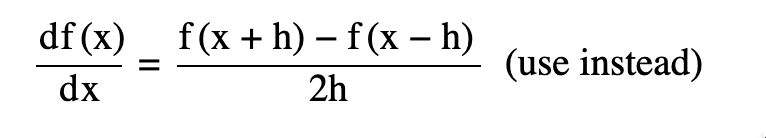

5. Calculate diff of 2 to 4 as: 

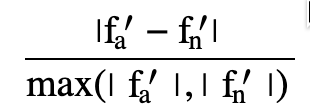

In [331]:
# gradient_input_data = test_data[:,:2]
# #gradient_input_data = np.expand_dims(gradient_input_data, axis=1)
# gradient_label = test_labels[:2,:]
# #gradient_label = np.expand_dims(gradient_label, axis=1)
# print(gradient_input_data.shape)
# print(gradient_label.shape)

# caxx = model_weights(gradient_input_data)
# h = 1e-6
# fake_cache_pos = fake_cache_minus = app_grad = caxx

# for k, v in cache.items():

#     if k[0] == 'W' or k[0] == 'b':

#         for i in tqdm(range(v.shape[0])):
#             for j in range(v.shape[1]):

#                 fake_cache_pos[k][i][j] = v[i][j] + h
#                 fake_cache_minus[k][i][j] = v[i][j] - h
#                 grad_plus_loss, _, _, _ = test(gradient_input_data, gradient_label, loss_fn=cross_entropy, cache=fake_cache_pos)
#                 grad_minus_loss, _, _, _ = test(gradient_input_data, gradient_label, loss_fn=cross_entropy, cache=fake_cache_minus)
#                 app_grad[k][i][j] = (grad_plus_loss - grad_minus_loss) / (2*h)

# for k, v in app_grad.items():
#     print(f"app_grads - k: {k} || shape: {v.shape}")

# _, _, _, _, analytic_grad = train(gradient_input_data, gradient_label, learning_rate=learning_rate, loss_fn=cross_entropy, cache=caxx, batch_size=2, reg=1, iter=1)
# for k, v in analytic_grad.items():
#     print(f"anal_grad - k: {k} || shape: {v.shape}")

In [332]:
# app_grad_vec = np.zeros((0,0))
# for k, v in app_grad.items():
#     # if k[0] != 'W' or k[0] != 'b':
#     #     app_grad.pop(k)
#     if k[0] == 'W':
#         app_grad_vec = np.concatenate((app_grad_vec, app_grad[k]), axis=None)

# for k, v in app_grad.items():
#     # if k[0] != 'W' or k[0] != 'b':
#     #     app_grad.pop(k)
#     if k[0] == 'b':
#         app_grad_vec = np.concatenate((app_grad_vec, app_grad[k]), axis=None)

# anal_grad_vec = np.zeros((0,0))

# for k, v in analytic_grad.items():
#     anal_grad_vec = np.concatenate((anal_grad_vec, analytic_grad[k]), axis=None)

# print(anal_grad_vec.shape)
# print(app_grad_vec.shape)

# num = np.linalg.norm(app_grad_vec - anal_grad_vec)
# den = np.linalg.norm(anal_grad_vec)+ np.linalg.norm(app_grad_vec)

# diff = num / den

# print(num)
# print(den)
# print(diff)

No Work kkkkkk

# Dropout Regularization
Implementing dropout regularization - must adjust the forward and backward calculations, as such:

    forward: 
        1. for each hidden_layer, multiplying each neuron by a probability or remaining in the pass
        2. saving the eliminated neurons mask for backprop

    backward: 
        1. after each calculation of the derivative of the activation function this data must be multiplied by the mask from forward prop, zeroing out the neurons that were not activated
        2. after changing the derivative of the activ funct, dividing it by the prob of keeping the neurons so the deriv gets weighted on the number of active neurons

Eu rodei essa bagaça la em cima this is just for ref

In [333]:
# def dropout(input, keep_prob):
#     '''gets weight matrix and prob estimate'''
#     D = np.random.rand(*input.shape)
#     mask = D < keep_prob
#     adj_input = input * mask
#     adj_input = adj_input / keep_prob

#     return adj_input, mask, keep_prob

# def dropout_backprop(dA, mask, keep_prob):
#     ddrop = dA * mask
#     ddrop = ddrop / keep_prob

#     return ddrop

# Batch Norm

Forward:
    Applies a normalization through the batch data [x = (param, batch_size)]. Following the image below

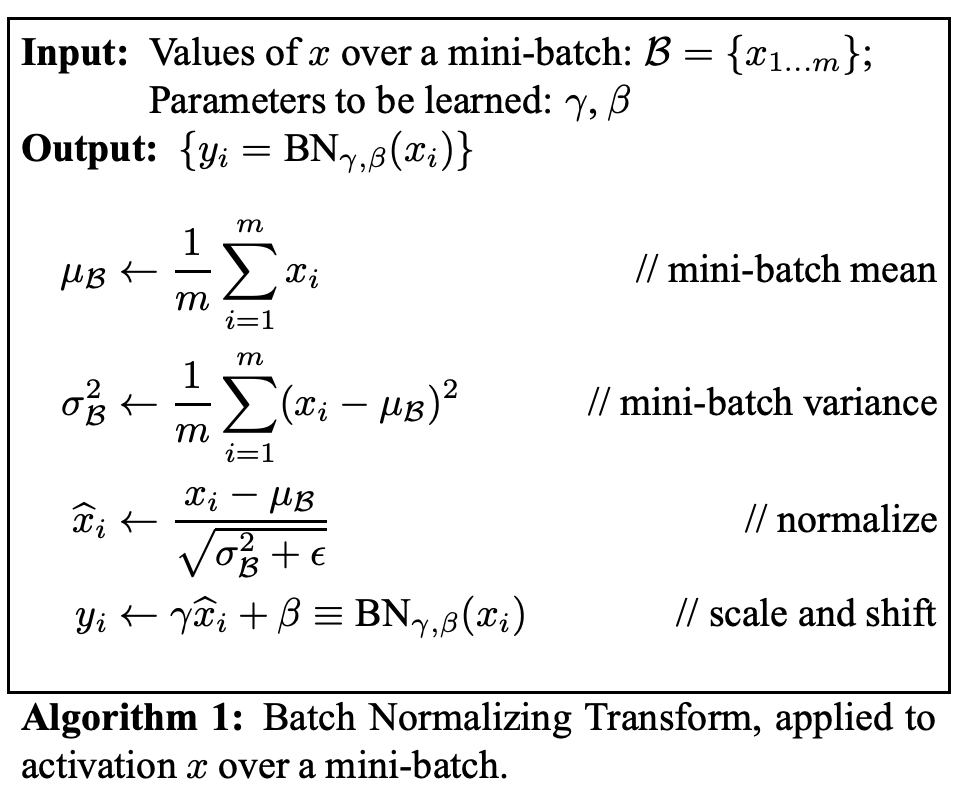

Therefore we need to understand which elements to save (for backprop), which are:
1. x_hat_i
2. xi
3. mean_b
4. std_dev_b
5. lambda
6. beta
7. epsilon

Rodei essa bagaca la em cima, this is just for ref .2 and it is wrong

In [334]:
# def batch_norm_forward(batch, gamma=1, beta=0.1, eps=1e-5):
    
#     mean_b = np.mean(batch, axis=1, keepdims=True)

#     std_b = np.mean((batch - mean_b)**2, axis=1,keepdims=True)

#     x_hat = (batch - mean_b) / ((std_b + eps)**2)

#     out = gamma * x_hat + beta
#     cache = (gamma, x_hat, std_b, mean_b, batch, eps)
#     return out, cache

# def batch_norm_backward(dout, cache):
#     gamma, x_hat, std_b, mean_b, batch, eps = cache
#     _, N = batch.shape

#     dgamma = np.sum(dout * x_hat, axis=0, keepdims=True)
#     dbeta = np.sum(dout, axis=0, keepdims=True)
#     dx_hat = dout * gamma #is it a vector?
#     dx_std = np.sum(dx_hat * ( -1/2*(batch - mean_b)*(std_b + eps)**(-3/2)), axis=1, keepdims=True)
#     dx_mu = np.sum(dx_hat * -1* (std_b + eps)**(1/2), axis=1, keepdims=True) + dx_std * np.sum(-2* (batch-mean_b))/N
#     dx = dx_mu * 1/N + dx_std * 2* (batch-mean_b)/N + dx_hat * (std_b+eps)**(1/2)


#     return dx, dgamma, dbeta

# mini_bitch = cache["A1"]
# print(mini_bitch.shape)
# out, norm_cax = batch_norm_forward(mini_bitch)
# dx, dgamma, dbeta = batch_norm_backward(cache["A1"], norm_cax)
print(cache['gamma1'].shape)
print(cache['gamma2'].shape)
print(cache['beta1'].shape)
print(cache['beta2'].shape)
print(cache['N1'].shape)
print(cache["A1"].shape)
print(cache["A2"].shape)
print(cache['N2'].shape)


(1024, 1)
(512, 1)
(1024, 1)
(512, 1)
(1024, 60000)
(1024, 60000)
(512, 60000)
(512, 60000)
